In [ ]:
## https://github.com/estnltk/syntax_experiments/blob/semantic_labelling/rule_based_semantic_categorisation/elusolendid.srt

# peaks panema mingi limiidi sest nt 'päev' ei ole elusolend

In [17]:
import os
import pandas as pd
from estnltk import Text
from tqdm import tqdm
from itertools import chain
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support,accuracy_score, auc, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve

In [2]:
with open("elusolendid.srt", "r") as f:
    faildata = f.readlines()

faildata = [row.strip() for row in faildata]
elusolendid = [elem.split(" ",1)[1].strip() for elem in faildata]

In [3]:
elusolendid

['inimene',
 'mees',
 'isik',
 'naine',
 'laps',
 'riik',
 'liige',
 'noormees',
 'töötaja',
 'firma',
 'poiss',
 'kodanik',
 'tüdruk',
 'juht',
 'noor',
 'eestlane',
 'ametnik',
 'esindaja',
 'poliitik',
 'sõber',
 'ema',
 'ettevõtja',
 'meeskond',
 'klient',
 'tegelane',
 'rahvas',
 'elanik',
 'mängija',
 'õpilane',
 'nimi',
 'ettevõte',
 'küsimus',
 'omanik',
 'politseinik',
 'õpetaja',
 'arst',
 'pere',
 'kandidaat',
 'asutus',
 'ajakirjanik',
 'seltskond',
 'valitsus',
 'kunstnik',
 'vanem',
 'näitleja',
 'isa',
 'ärimees',
 'president',
 'erakond',
 'poeg',
 'loom',
 'spetsialist',
 'liikmesriik',
 'koer',
 'välismaalane',
 'patsient',
 'sportlane',
 'jõud',
 'tudeng',
 'arv',
 'kolleeg',
 'tootja',
 'komisjon',
 'tüüp',
 'neiu',
 'investor',
 'sõdur',
 'minister',
 'põlvkond',
 'pensionär',
 'üliõpilane',
 'perekond',
 'kirjanik',
 'organisatsioon',
 'grupp',
 'nooruk',
 'politsei',
 'soomlane',
 'autor',
 'tuttav',
 'vend',
 'autojuht',
 'venelane',
 'daam',
 'teadlane',
 'omav

In [4]:
data = pd.read_csv("obl_1000_benchmark.csv", sep=";", encoding="utf-8")
data

,id,fpath,sentence,remove_start,remove_end,removed,type,short_sent,cons_score,ual,la,removetype,short_sent_untoken,sentence_analysis_data,peasona,verb,label
0,1051,Train/tea_eesti_arst_2004_osa_3_ud211.conllu,"Seda ka kohe-kohe algavatel järjekordsetel palgaläbirääkimistel , kus just perearste arvestades on põhjust peale haiglate liidu osaleda ka Haigekassal .",107,127,peale haiglate liidu,free,"Seda ka kohe-kohe algavatel järjekordsetel palgaläbirääkimistel , kus just perearste arvestades on põhjust osaleda ka Haigekassal .",58.8,64.7,82.4,yes,"Seda ka kohe-kohe algavatel järjekordsetel palgaläbirääkimistel, kus just perearste arvestades on põhjust osaleda ka Haigekassal.","('peale', 13, 16, 'osaleda', 17)",peale,osaleda,1
1,1389,Train/aja_luup200106_osa_2_ud211.conllu,"Kuna eestlased hindavad oma kodu kõrgelt , siis on nende 5-10 % kinnisvaramiljonäride näol tegemist enamasti mingi ooteperioodiga või ettevõtluse algstaadiumiga , mis ei luba teenitud ettevõtlustulu veel elamispinda investeerida .",204,215,elamispinda,free,"Kuna eestlased hindavad oma kodu kõrgelt , siis on nende 5-10 % kinnisvaramiljonäride näol tegemist enamasti mingi ooteperioodiga või ettevõtluse algstaadiumiga , mis ei luba teenitud ettevõtlustulu veel investeerida .",20.0,23.3,33.3,yes,"Kuna eestlased hindavad oma kodu kõrgelt, siis on nende 5-10% kinnisvaramiljonäride näol tegemist enamasti mingi ooteperioodiga või ettevõtluse algstaadiumiga, mis ei luba teenitud ettevõtlustulu veel investeerida.","('elamispinda', 28, 30, 'investeerida', 30)",elamispinda,investeerida,1
2,1109,Train/aja_pm20000218_osa_5_ud211.conllu,"Järgnevalt anti Marsile kiiresti mitu käsku , lootuses , et kosmosesõiduk - kui see oli signaali allikas - annaks signaale edasi samal lainepikkusel , kuid Stanfordi antenn ei avastanud midagi .",16,23,Marsile,free,"Järgnevalt anti kiiresti mitu käsku , lootuses , et kosmosesõiduk - kui see oli signaali allikas - annaks signaale edasi samal lainepikkusel , kuid Stanfordi antenn ei avastanud midagi .",86.7,86.7,96.7,yes,"Järgnevalt anti kiiresti mitu käsku, lootuses, et kosmosesõiduk - kui see oli signaali allikas - annaks signaale edasi samal lainepikkusel, kuid Stanfordi antenn ei avastanud midagi.","('Marsile', 2, 2, 'anti', 2)",Marsile,anti,1
3,398,Train/aja_luup200202_osa_1_ud211.conllu,"Enne minekut hoiatab ta oma leebel moel , et äri ei tohiks haiglas küll ülimaks eesmärgiks saada .",59,66,haiglas,free,"Enne minekut hoiatab ta oma leebel moel , et äri ei tohiks küll ülimaks eesmärgiks saada .",100.0,100.0,100.0,yes,"Enne minekut hoiatab ta oma leebel moel, et äri ei tohiks küll ülimaks eesmärgiks saada.","('haiglas', 12, 17, 'saada', 17)",haiglas,saada,1
4,2346,Train/arborest_ud211.conllu,Peeter kargas läbi akna aeda kuue järele .,24,28,aeda,free,Peeter kargas läbi akna kuue järele .,100.0,100.0,100.0,yes,Peeter kargas läbi akna kuue järele.,"('aeda', 4, 2, 'kargas', 2)",aeda,kargas,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1961,Train/arborest_ud211.conllu,Tuul loobib pilve ühest kohast teise .,18,30,ühest kohast,bound,Tuul loobib pilve teise .,100.0,100.0,100.0,no,Tuul loobib pilve teise.,"('kohast', 4, 2, 'loobib', 2)",kohast,loobib,0
996,1831,Train/aja_sloleht20071217_ud211.conllu,""" Esimest korda julgeti mind kutsuda mingit teemat kommenteerima aastal 1985 .",65,76,aastal 1985,bound,""" Esimest korda julgeti mind kutsuda mingit teemat kommenteerima .",100.0,100.0,100.0,no,""" Esimest korda julgeti mind kutsuda mingit teemat kommenteerima.","('aastal', 9, 9, 'kommenteerima', 9)",aastal,kommenteerima,0
997,97,Train/aja_luup200106_osa_2_ud211.conllu,"Tõusevad praktiliselt kõik hinnad , suhkur mitu korda , kütus aktsiisi võrra - paar krooni liitrilt , sigarettidel on miinimumnõue 57 % paki hinnast .",116,128,sigarettidel,bound,"Tõusevad praktiliselt kõik hinnad , suhkur mitu korda , kütus aktsiisi võrra - paar krooni liitrilt , sigarettidel oue 57 % paki hinnast .",NaN,NaN,NaN,no,"Tõusevad praktilis

In [5]:
def get_time_loc(phrase, elus):
    text = Text(phrase)
    text = text.tag_layer('morph_analysis')
    
    phrase_lemmas = list(set(chain.from_iterable(list(text["morph_analysis"].lemma))))    
    phrase_is_elus = False
    
    if phrase in elus:
        phrase_is_elus = True

    for lem in phrase_lemmas:
        if lem in elus:
            phrase_is_elus = True

    return phrase_is_elus

In [6]:
is_elus_data = []

for i in tqdm(range(len(data))):
    phrase = data.iloc[i]["removed"]        
    is_elus = get_time_loc(phrase, elusolendid)    
    is_elus_data.append(is_elus)

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 544.13it/s]


In [7]:
data["phrase_is_elusolend"] = is_elus_data
data["can_be_removed"] = "no"
data["remove_label"] = 0

In [8]:
data.loc[data.phrase_is_elusolend == False, 'can_be_removed'] = "yes"
data.loc[data.phrase_is_elusolend == False, 'remove_label'] = 1

In [9]:
data

,id,fpath,sentence,remove_start,remove_end,removed,type,short_sent,cons_score,ual,la,removetype,short_sent_untoken,sentence_analysis_data,peasona,verb,label,phrase_is_elusolend,can_be_removed,remove_label
0,1051,Train/tea_eesti_arst_2004_osa_3_ud211.conllu,"Seda ka kohe-kohe algavatel järjekordsetel palgaläbirääkimistel , kus just perearste arvestades on põhjust peale haiglate liidu osaleda ka Haigekassal .",107,127,peale haiglate liidu,free,"Seda ka kohe-kohe algavatel järjekordsetel palgaläbirääkimistel , kus just perearste arvestades on põhjust osaleda ka Haigekassal .",58.8,64.7,82.4,yes,"Seda ka kohe-kohe algavatel järjekordsetel palgaläbirääkimistel, kus just perearste arvestades on põhjust osaleda ka Haigekassal.","('peale', 13, 16, 'osaleda', 17)",peale,osaleda,1,True,no,0
1,1389,Train/aja_luup200106_osa_2_ud211.conllu,"Kuna eestlased hindavad oma kodu kõrgelt , siis on nende 5-10 % kinnisvaramiljonäride näol tegemist enamasti mingi ooteperioodiga või ettevõtluse algstaadiumiga , mis ei luba teenitud ettevõtlustulu veel elamispinda investeerida .",204,215,elamispinda,free,"Kuna eestlased hindavad oma kodu kõrgelt , siis on nende 5-10 % kinnisvaramiljonäride näol tegemist enamasti mingi ooteperioodiga või ettevõtluse algstaadiumiga , mis ei luba teenitud ettevõtlustulu veel investeerida .",20.0,23.3,33.3,yes,"Kuna eestlased hindavad oma kodu kõrgelt, siis on nende 5-10% kinnisvaramiljonäride näol tegemist enamasti mingi ooteperioodiga või ettevõtluse algstaadiumiga, mis ei luba teenitud ettevõtlustulu veel investeerida.","('elamispinda', 28, 30, 'investeerida', 30)",elamispinda,investeerida,1,False,yes,1
2,1109,Train/aja_pm20000218_osa_5_ud211.conllu,"Järgnevalt anti Marsile kiiresti mitu käsku , lootuses , et kosmosesõiduk - kui see oli signaali allikas - annaks signaale edasi samal lainepikkusel , kuid Stanfordi antenn ei avastanud midagi .",16,23,Marsile,free,"Järgnevalt anti kiiresti mitu käsku , lootuses , et kosmosesõiduk - kui see oli signaali allikas - annaks signaale edasi samal lainepikkusel , kuid Stanfordi antenn ei avastanud midagi .",86.7,86.7,96.7,yes,"Järgnevalt anti kiiresti mitu käsku, lootuses, et kosmosesõiduk - kui see oli signaali allikas - annaks signaale edasi samal lainepikkusel, kuid Stanfordi antenn ei avastanud midagi.","('Marsile', 2, 2, 'anti', 2)",Marsile,anti,1,False,yes,1
3,398,Train/aja_luup200202_osa_1_ud211.conllu,"Enne minekut hoiatab ta oma leebel moel , et äri ei tohiks haiglas küll ülimaks eesmärgiks saada .",59,66,haiglas,free,"Enne minekut hoiatab ta oma leebel moel , et äri ei tohiks küll ülimaks eesmärgiks saada .",100.0,100.0,100.0,yes,"Enne minekut hoiatab ta oma leebel moel, et äri ei tohiks küll ülimaks eesmärgiks saada.","('haiglas', 12, 17, 'saada', 17)",haiglas,saada,1,True,no,0
4,2346,Train/arborest_ud211.conllu,Peeter kargas läbi akna aeda kuue järele .,24,28,aeda,free,Peeter kargas läbi akna kuue järele .,100.0,100.0,100.0,yes,Peeter kargas läbi akna kuue järele.,"('aeda', 4, 2, 'kargas', 2)",aeda,kargas,1,True,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1961,Train/arborest_ud211.conllu,Tuul loobib pilve ühest kohast teise .,18,30,ühest kohast,bound,Tuul loobib pilve teise .,100.0,100.0,100.0,no,Tuul loobib pilve teise.,"('kohast', 4, 2, 'loobib', 2)",kohast,loobib,0,True,no,0
996,1831,Train/aja_sloleht20071217_ud211.conllu,""" Esimest korda julgeti mind kutsuda mingit teemat kommenteerima aastal 1985 .",65,76,aastal 1985,bound,""" Esimest korda julgeti mind kutsuda mingit teemat kommenteerima .",100.0,100.0,100.0,no,""" Esimest korda julgeti mind kutsuda mingit teemat kommenteerima.","('aastal', 9, 9, 'kommenteerima', 9)",aastal,kommenteerima,0,True,no,0
997,97,Train/aja_luup200106_osa_2_ud211.conllu,"Tõusevad praktiliselt kõik hinnad , suhkur mitu korda , kütus aktsiisi võrra - paar krooni liitrilt , sigarettidel on miinimumnõue 57 % paki hinnast .",116,128,sigarettidel,bound,"Tõusevad praktiliselt kõik hinnad , suhk

In [11]:
predicted = list(data['remove_label'])
y_test = list(data['label'])

precision, recall, fscore, support = score(y_test, predicted)

print('precision: {}'.format(precision.round(3)))
print('recall: {}'.format(recall.round(3)))
print('fscore: {}'.format(fscore.round(3)))
print('support: {}'.format(support.round(3)))

try:
    precision = precision_score(y_test, predicted, pos_label=1, average='binary')
    recall = recall_score(y_test, predicted, pos_label=1, average='binary')
except:
    precision = precision_score(y_test, predicted, labels=[1], average='micro')
    recall = recall_score(y_test, predicted, labels=[1], average='micro')
print('precision: ',precision.round(3))
print('recall: ',recall.round(3))

precision: [0.504 0.508]
recall: [0.7  0.31]
fscore: [0.586 0.385]
support: [500 500]
precision:  0.508
recall:  0.31


In [12]:
data["match"] = data.remove_label.eq(data.label) # true if annotation and prediction are the same

In [13]:
data.value_counts("match")

match
True     505
False    495
Name: count, dtype: int64

In [14]:
data.value_counts("remove_label")

remove_label
0    695
1    305
Name: count, dtype: int64

In [15]:
# Compute global precision and recall
precision1, recall1, thresh1 = precision_recall_curve(y_test, predicted, pos_label=1)

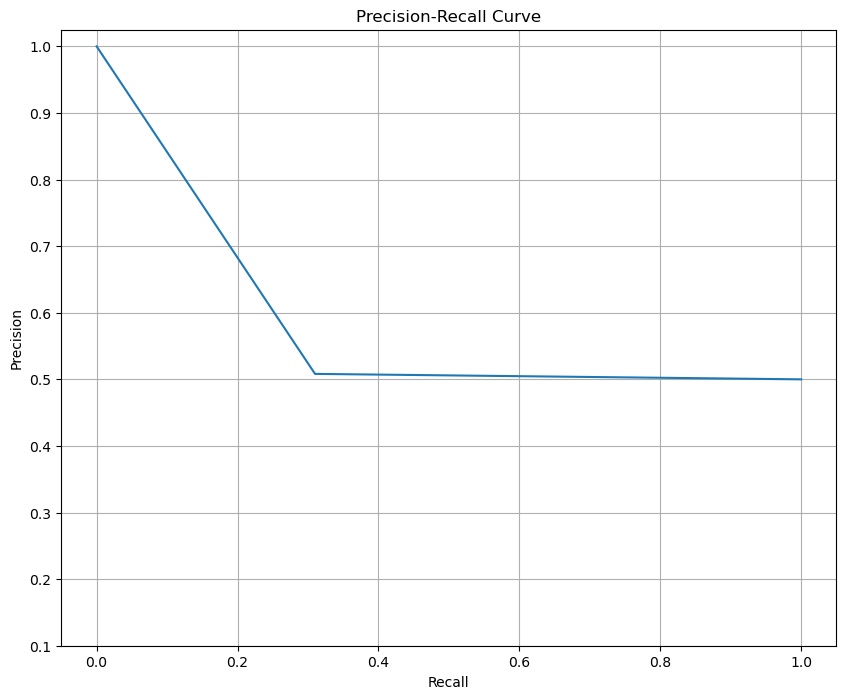

In [18]:
# Plot the precision-recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall1, precision1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.grid(True)
plt.show()

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, predicted, pos_label=1)

In [20]:
roc_auc = auc(fpr, tpr)

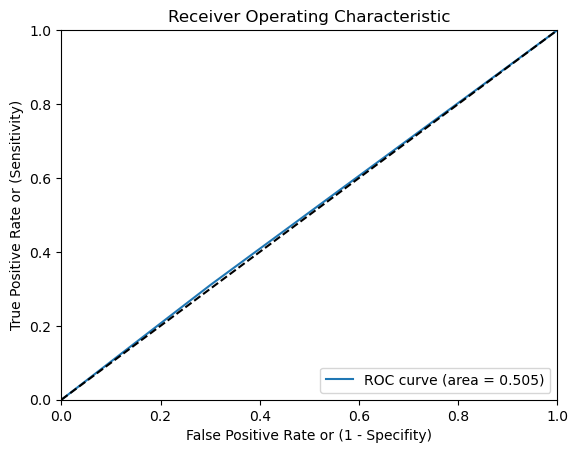

In [21]:
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [22]:
#data.to_csv("obl_gpt_large1_elusolend_lemma_benchmark_v1.csv", index=False, sep=";", encoding="utf-8")